<a href="https://colab.research.google.com/github/alexander-toschev/cv-course/blob/main/FBA_PoseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2
import glob
import numpy as np
import cv2
import sys
from pil import Image
import cv2
import numpy as np
import math
from IPython.display import display

data/calib\left01.jpg


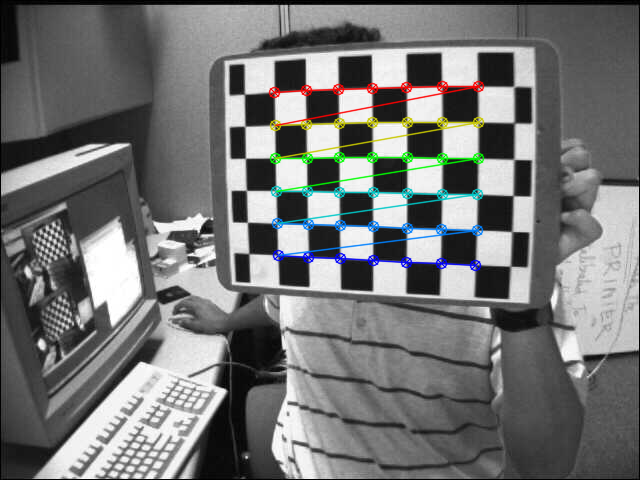

data/calib\left02.jpg


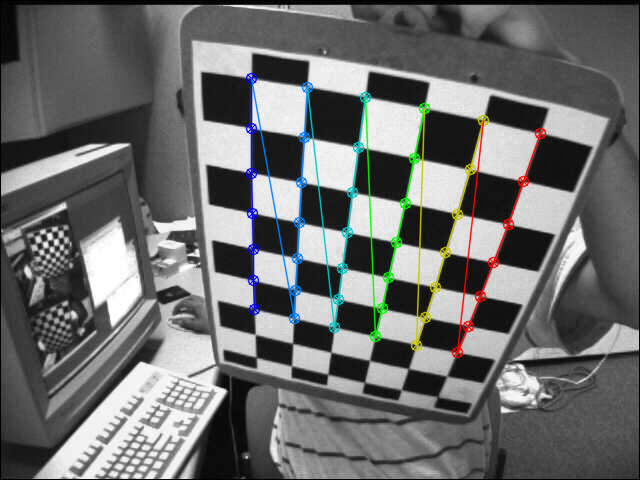

data/calib\left03.jpg


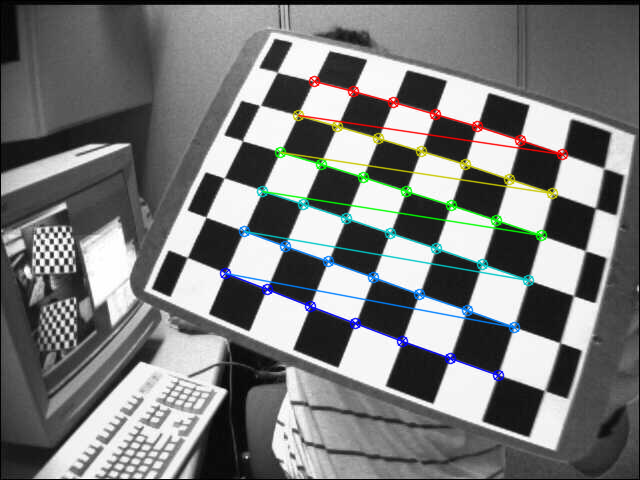

data/calib\left04.jpg


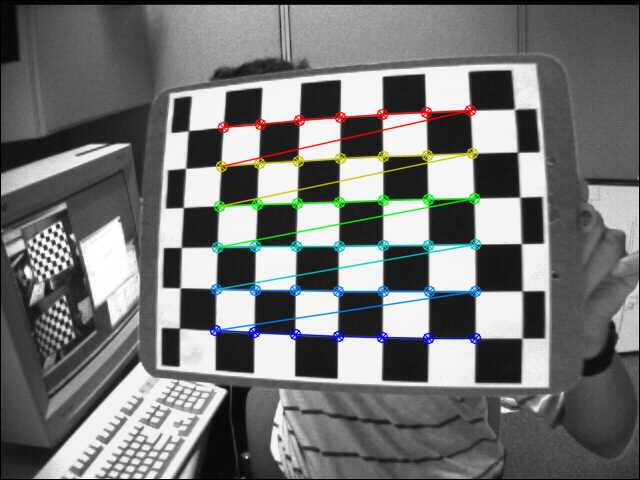

data/calib\left05.jpg


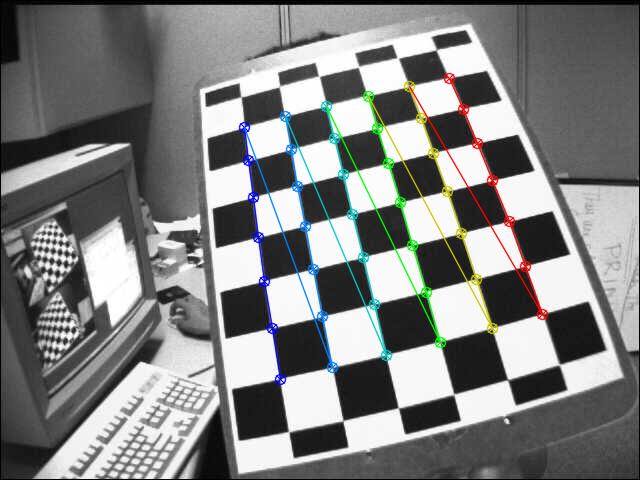

data/calib\left06.jpg


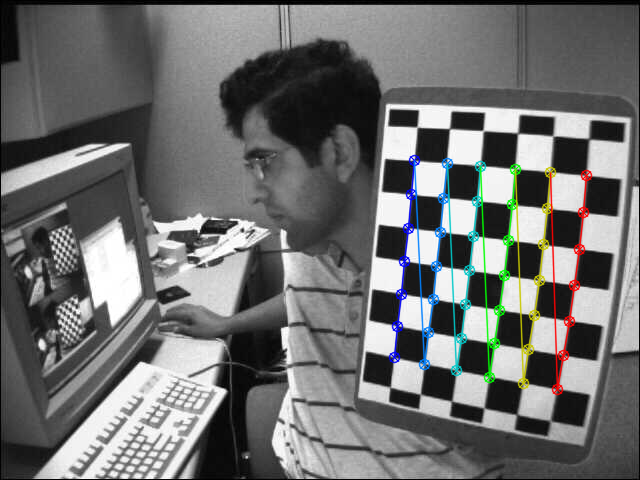

data/calib\left12.jpg


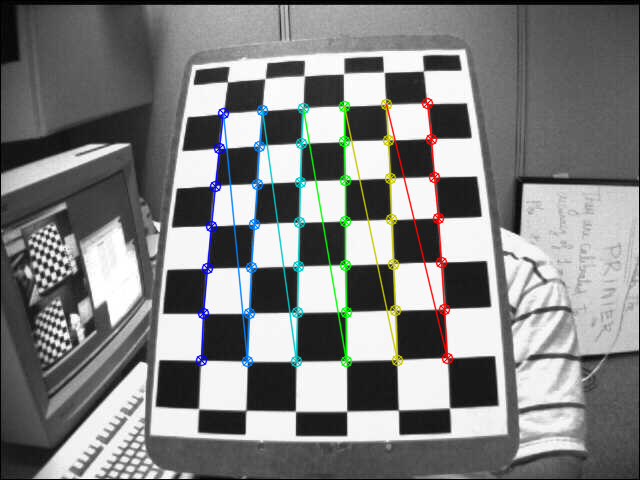

In [4]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('data/calib/*.jpg')

for fname in images:
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        display(Image.fromarray(img))
        # cv2.imshow('img',img)
        # cv2.waitKey(500)

cv2.destroyAllWindows()

# Calibration
So now we have our object points and image points we are ready to go for calibration. For that we use the function, cv2.calibrateCamera(). It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Undistortion


We have got what we were trying. Now we can take an image and undistort it. OpenCV comes with two methods, we will see both. But before that, we can refine the camera matrix based on a free scaling parameter using cv2.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.

So we take a new image (left12.jpg in this case. That is the first image in this chapter)

In [9]:
img = cv2.imread('data/calib/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

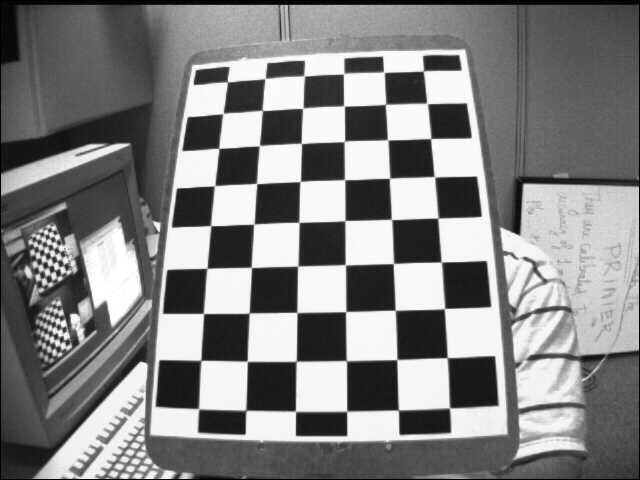

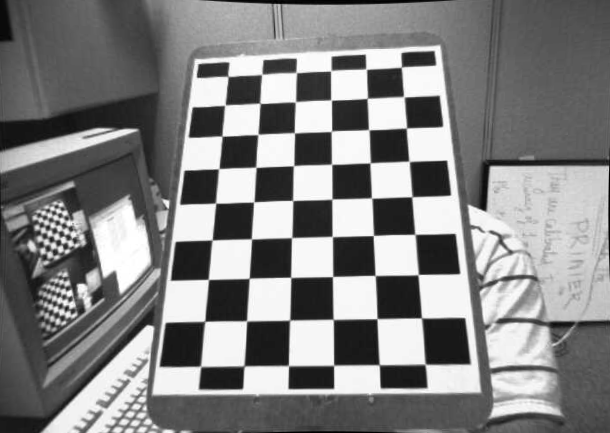

In [10]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

display(Image.fromarray(img))
display(Image.fromarray(dst))


# TODO
Undistort using 

mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)

dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# Re-projection Error

Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible. Given the intrinsic, distortion, rotation and translation matrices, we first transform the object point to image point using cv2.projectPoints(). Then we calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error we calculate the arithmetical mean of the errors calculate for all the calibration images.

In [11]:
mean_error = 0.0
for i in range(len(objpoints)):   
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    print(error)
    mean_error += error

print ('total error: ', mean_error/len(objpoints))

0.02591498692646372
0.01805996263312701
0.020776642580380953
0.02633343027314508
0.022425682366163664
0.020547614126883468
0.027248718316513525
total error:  0.023043862460382487


# Pose Estimation

Given a pattern image, we can utilize the above information to calculate its pose, or how the object is situated in space, like how it is rotated, how it is displaced etc. For a planar object, we can assume Z=0, such that, the problem now becomes how camera is placed in space to see our pattern image. So, if we know how the object lies in the space, we can draw some 2D diagrams in it to simulate the 3D effect. Let’s see how to do it.

Our problem is, we want to draw our 3D coordinate axis (X, Y, Z axes) on our chessboard’s first corner. X axis in blue color, Y axis in green color and Z axis in red color. So in-effect, Z axis should feel like it is perpendicular to our chessboard plane.

Then as in previous case, we create termination criteria, object points (3D points of corners in chessboard) and axis points. Axis points are points in 3D space for drawing the axis. We draw axis of length 3 (units will be in terms of chess square size since we calibrated based on that size). So our X axis is drawn from (0,0,0) to (3,0,0), so for Y axis. For Z axis, it is drawn from (0,0,0) to (0,0,-3). Negative denotes it is drawn towards the camera.

In [30]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

Now, as usual, we load each image. Search for 7x6 grid. If found, we refine it with subcorner pixels. Then to calculate the rotation and translation, we use the function, cv2.solvePnPRansac(). Once we those transformation matrices, we use them to project our axis points to the image plane. In simple words, we find the points on image plane corresponding to each of (3,0,0),(0,3,0),(0,0,3) in 3D space. Once we get them, we draw lines from the first corner to each of these points using our draw() function. Done !!!

[[[372.58105 259.964  ]]

 [[477.92548 158.38669]]

 [[471.17038 292.98444]]]


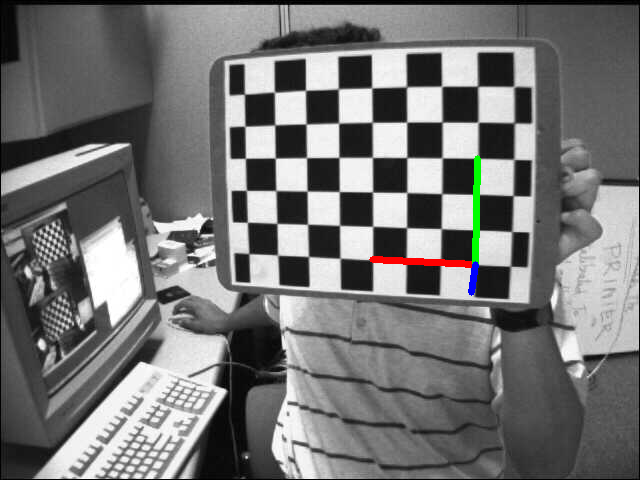

[[[251.81119 212.78522]]

 [[375.3055  335.9055 ]]

 [[210.85039 412.24844]]]


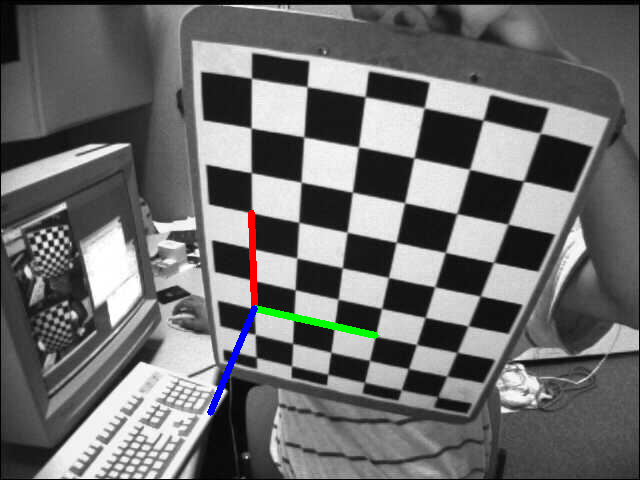

[[[355.25848 323.1225 ]]

 [[541.03546 235.35284]]

 [[530.0775  364.39328]]]


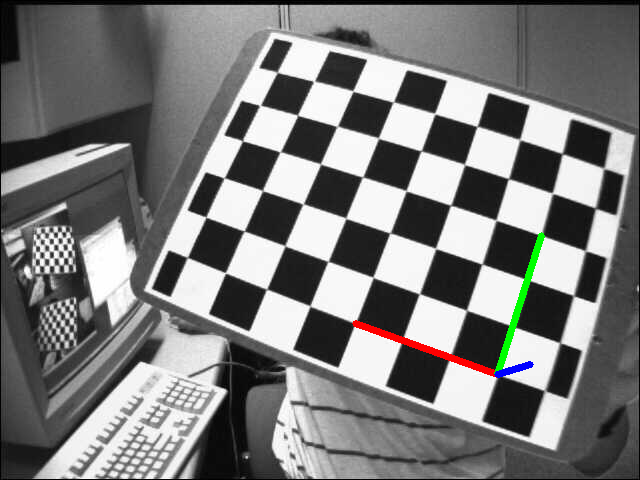

[[[337.47034 335.91492]]

 [[473.86212 197.94337]]

 [[476.45355 353.5583 ]]]


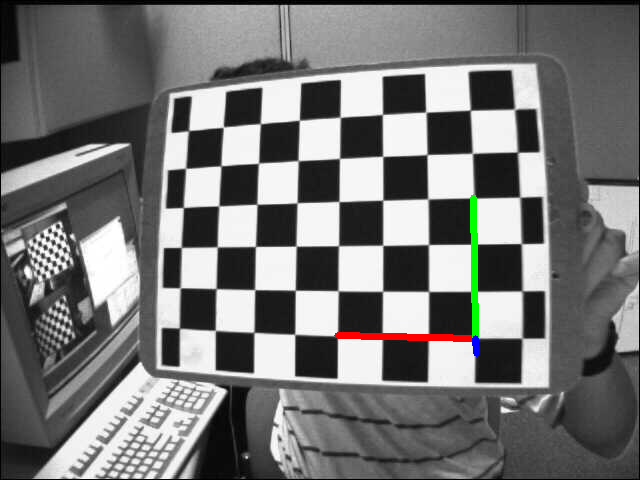

[[[258.25552 237.01775]]

 [[439.44293 341.5826 ]]

 [[224.23761 333.6157 ]]]


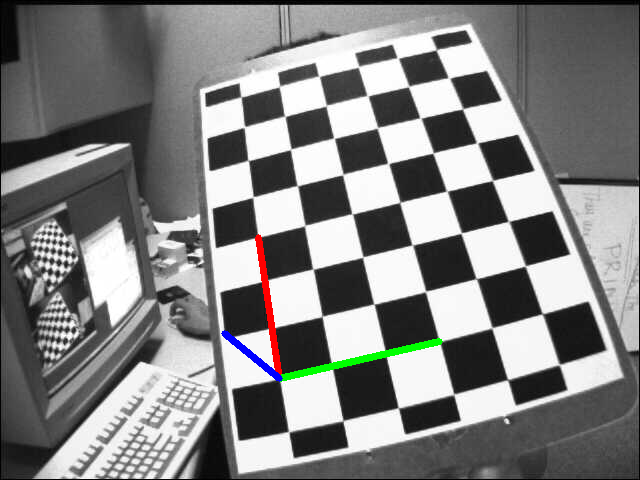

[[[404.30527 260.91113]]

 [[489.2694  376.38272]]

 [[353.457   385.28217]]]


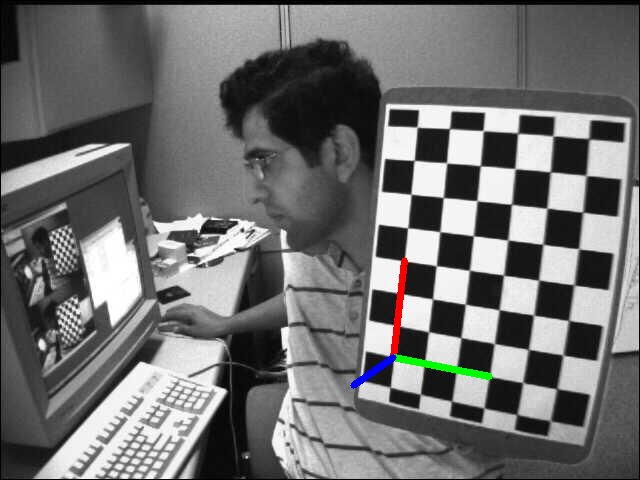

[[[210.67456 225.56573]]

 [[346.1948  360.76572]]

 [[139.36263 331.1497 ]]]


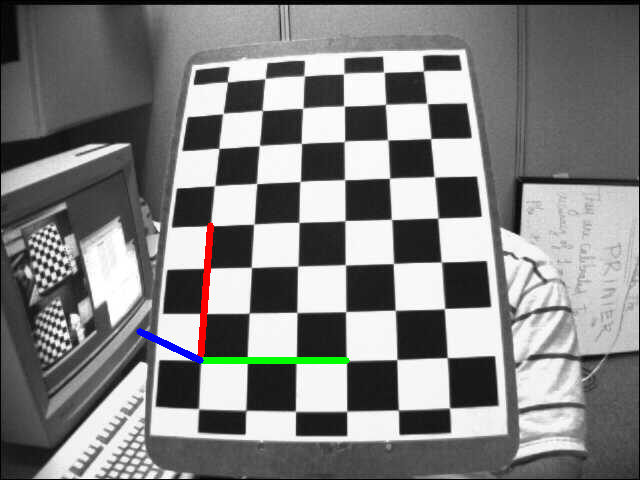

In [41]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img


for fname in glob.glob('data/calib/*.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        print(imgpts)
        img = draw(img,corners2.astype(int),imgpts.astype(int))
        display(Image.fromarray(img))
cv2.destroyAllWindows()